Load Glutamatergic Data

In [2]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
from bbknn import bbknn
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "G:/Shared drives/Opossum transcriptomics/Data/Allen/"
sample_IDs = ["NW_TX0055-4_S01_L003-001", "NW_TX0055-5_S01_L003-001", "NW_TX0055-6_S01_L003-001", "NW_TX0064-3_S01_L003-001", 
              "NW_TX0064-4_S01_L003-001", "NW_TX0064-5_S01_L003-001", "NW_TX0077-7_S01_L003-001", "NW_TX0077-8_S01_L003-001", 
              "NW_TX0078-1_S01_L003-001", "NW_TX0090-11_S01_L003-001", "NW_TX0092-7_S01_L003-001", "NW_TX0092-8_S01_L003-001"]
adata = sc.read_h5ad(data_path + "glut.h5ad")

Analyze Glutamatergic Cells

In [3]:
adata

AnnData object with n_obs × n_vars = 80042 × 18827
    obs: 'batch', 'class', 'n_genes', 'n_counts', 'leiden', 'doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

In [4]:
adata.X = adata.raw.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)


2023-05-04 10:49:56,550 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-04 10:50:17,853 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-04 10:50:18,450 - harmonypy - INFO - Iteration 1 of 10
2023-05-04 10:51:04,879 - harmonypy - INFO - Iteration 2 of 10
2023-05-04 10:51:50,879 - harmonypy - INFO - Iteration 3 of 10
2023-05-04 10:52:37,427 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:06)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


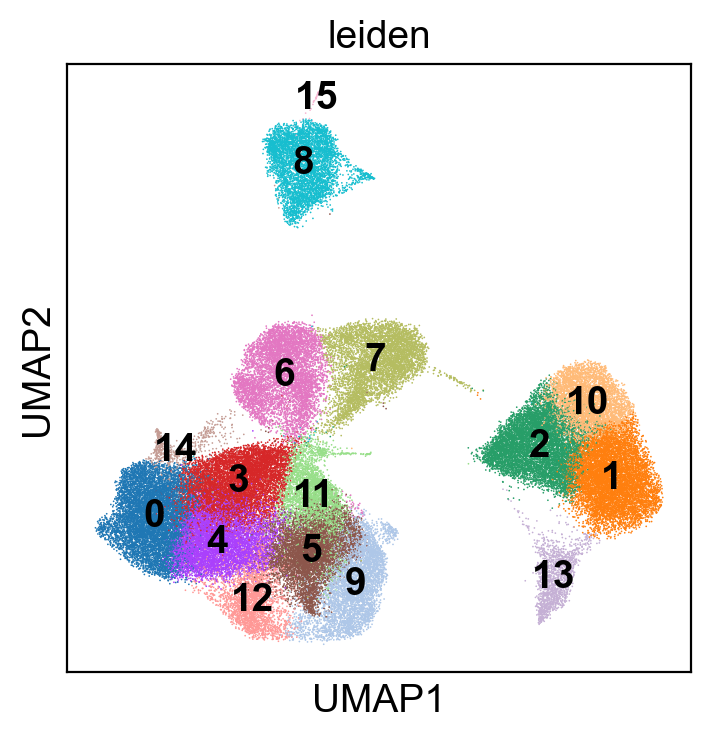

In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "batch")
# sc.pp.neighbors(adata_glut, n_neighbors=25, n_pcs=40)
# bbknn(adata, batch_key="batch", neighbors_within_batch=6)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


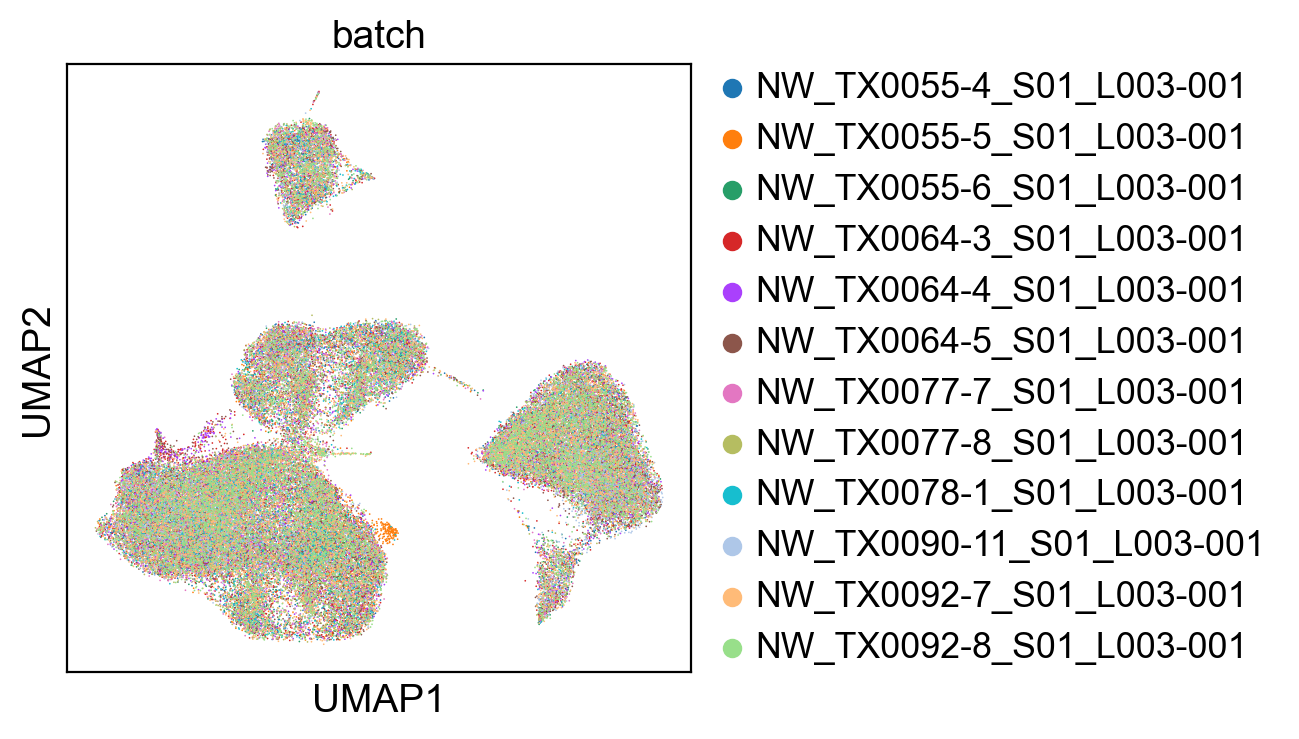

In [6]:
sc.pl.umap(adata, color=["batch"])
adata.obs["subclass"] = [None] * adata.shape[0]

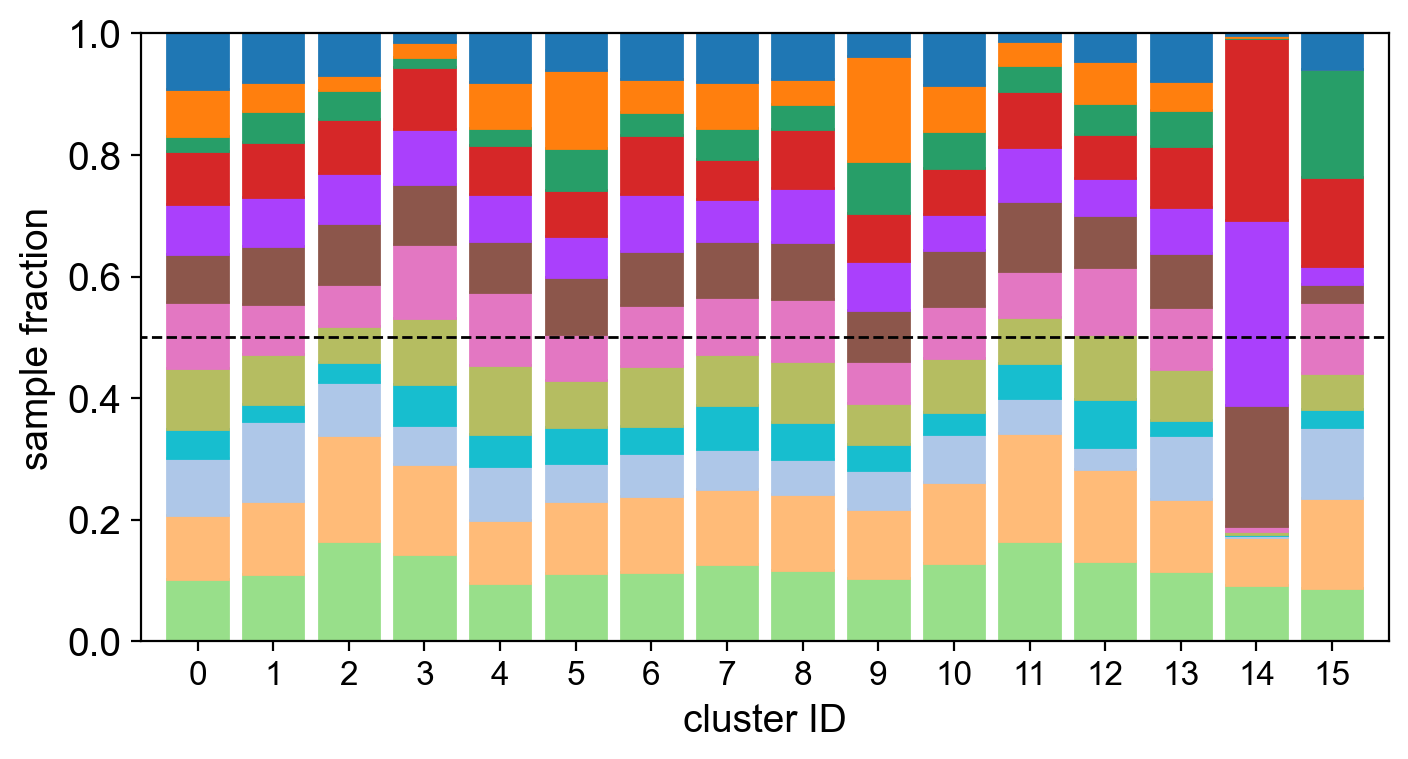

In [7]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in sample_IDs[::-1]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["batch"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["batch_colors"][::-1]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.hlines(0.5, -1, np.max(cluster_ids) + 1, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("sample fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

In [8]:
# Remove clusters if they arise from a single sample.
sample_cluster_ids = [14, 15]
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
for cluster in cluster_ids:
    if cluster in sample_cluster_ids:
        cluster_mask = adata.obs["leiden"] != str(cluster)
        adata = adata[cluster_mask, :]

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


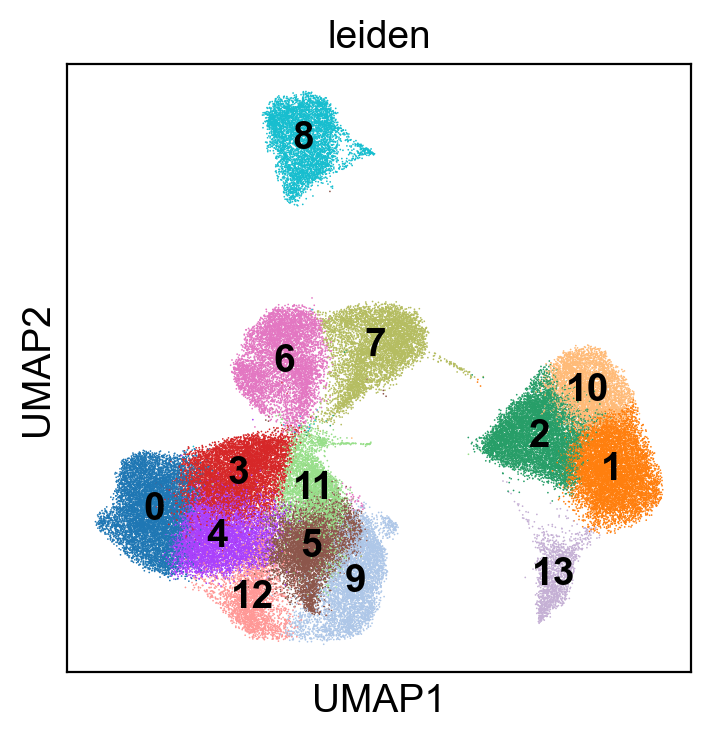

In [9]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

categories: 0, 1, 2, etc.
var_group_labels: General, 2/3, 234, etc.


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


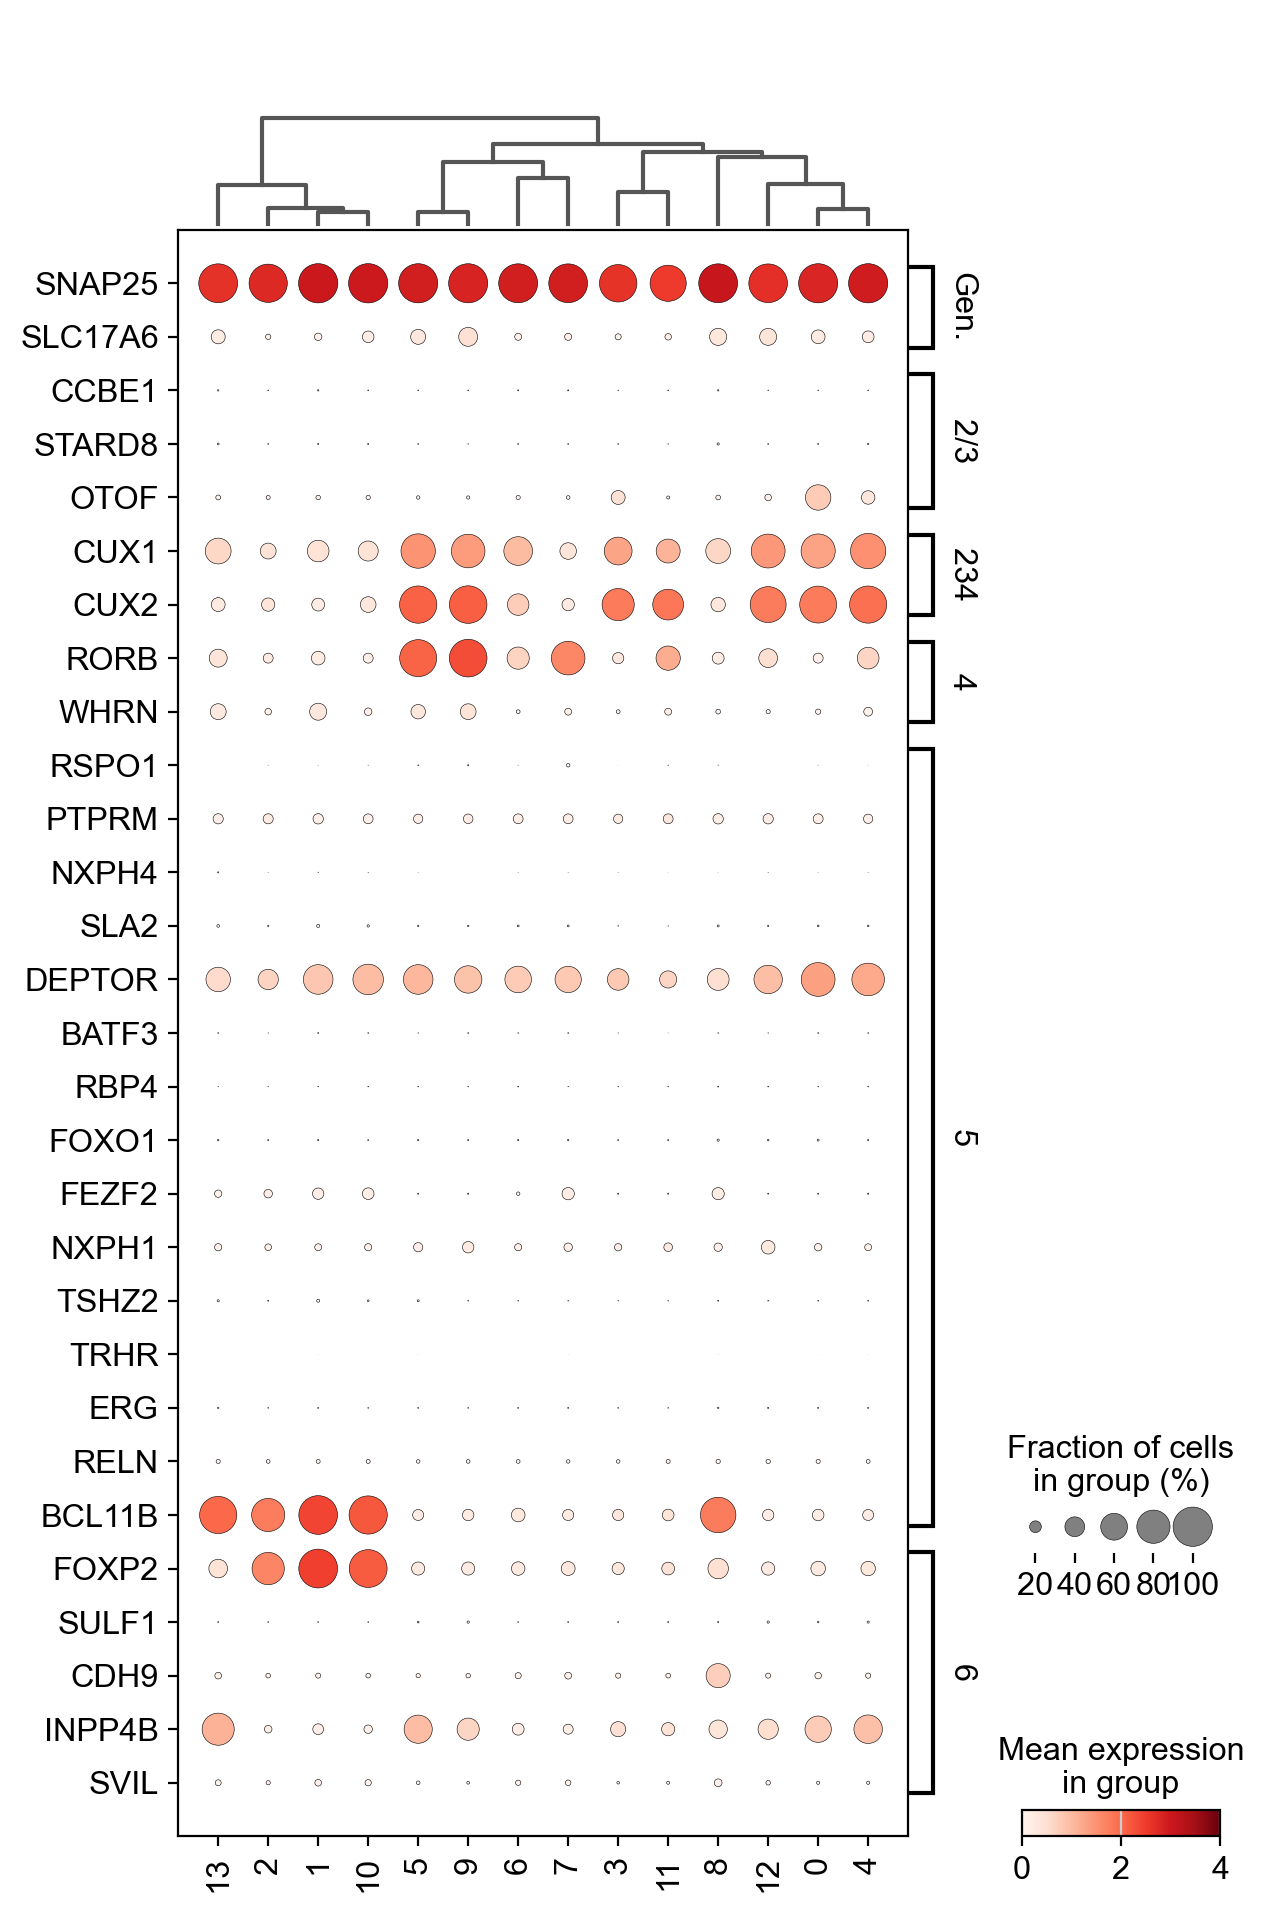

In [19]:
glutamatergic_markers = [
                         "SNAP25", "SLC17A6", # general
                         "CCBE1", "STARD8", "OTOF", # L2/3
                         "CUX1", "CUX2", # L2/3 & L4
                         "RORB", "WHRN", "RSPO1", # L4
                         "PTPRM", "NXPH4", "SLA2", 
                         "DEPTOR", "BATF3", "RBP4", "FOXO1", "FEZF2", "NXPH1", "TSHZ2", "TRHR", "ERG", "RELN", "BCL11B", # L5
                         "FOXP2", "SULF1", "CDH9", "INPP4B", "SVIL" # L6
                        ]

sc.pl.dotplot(
    adata, 
    glutamatergic_markers, 
    groupby="leiden", 
    dendrogram=True, 
    swap_axes=True, 
    vmin=0, vmax=4, 
    var_group_positions=[(0, 1), (2, 4), (5, 6), (7, 8), (9, 23), (24, 28)], 
    var_group_labels=["General", "2/3", "234", "4", "5", "6"], 
            )

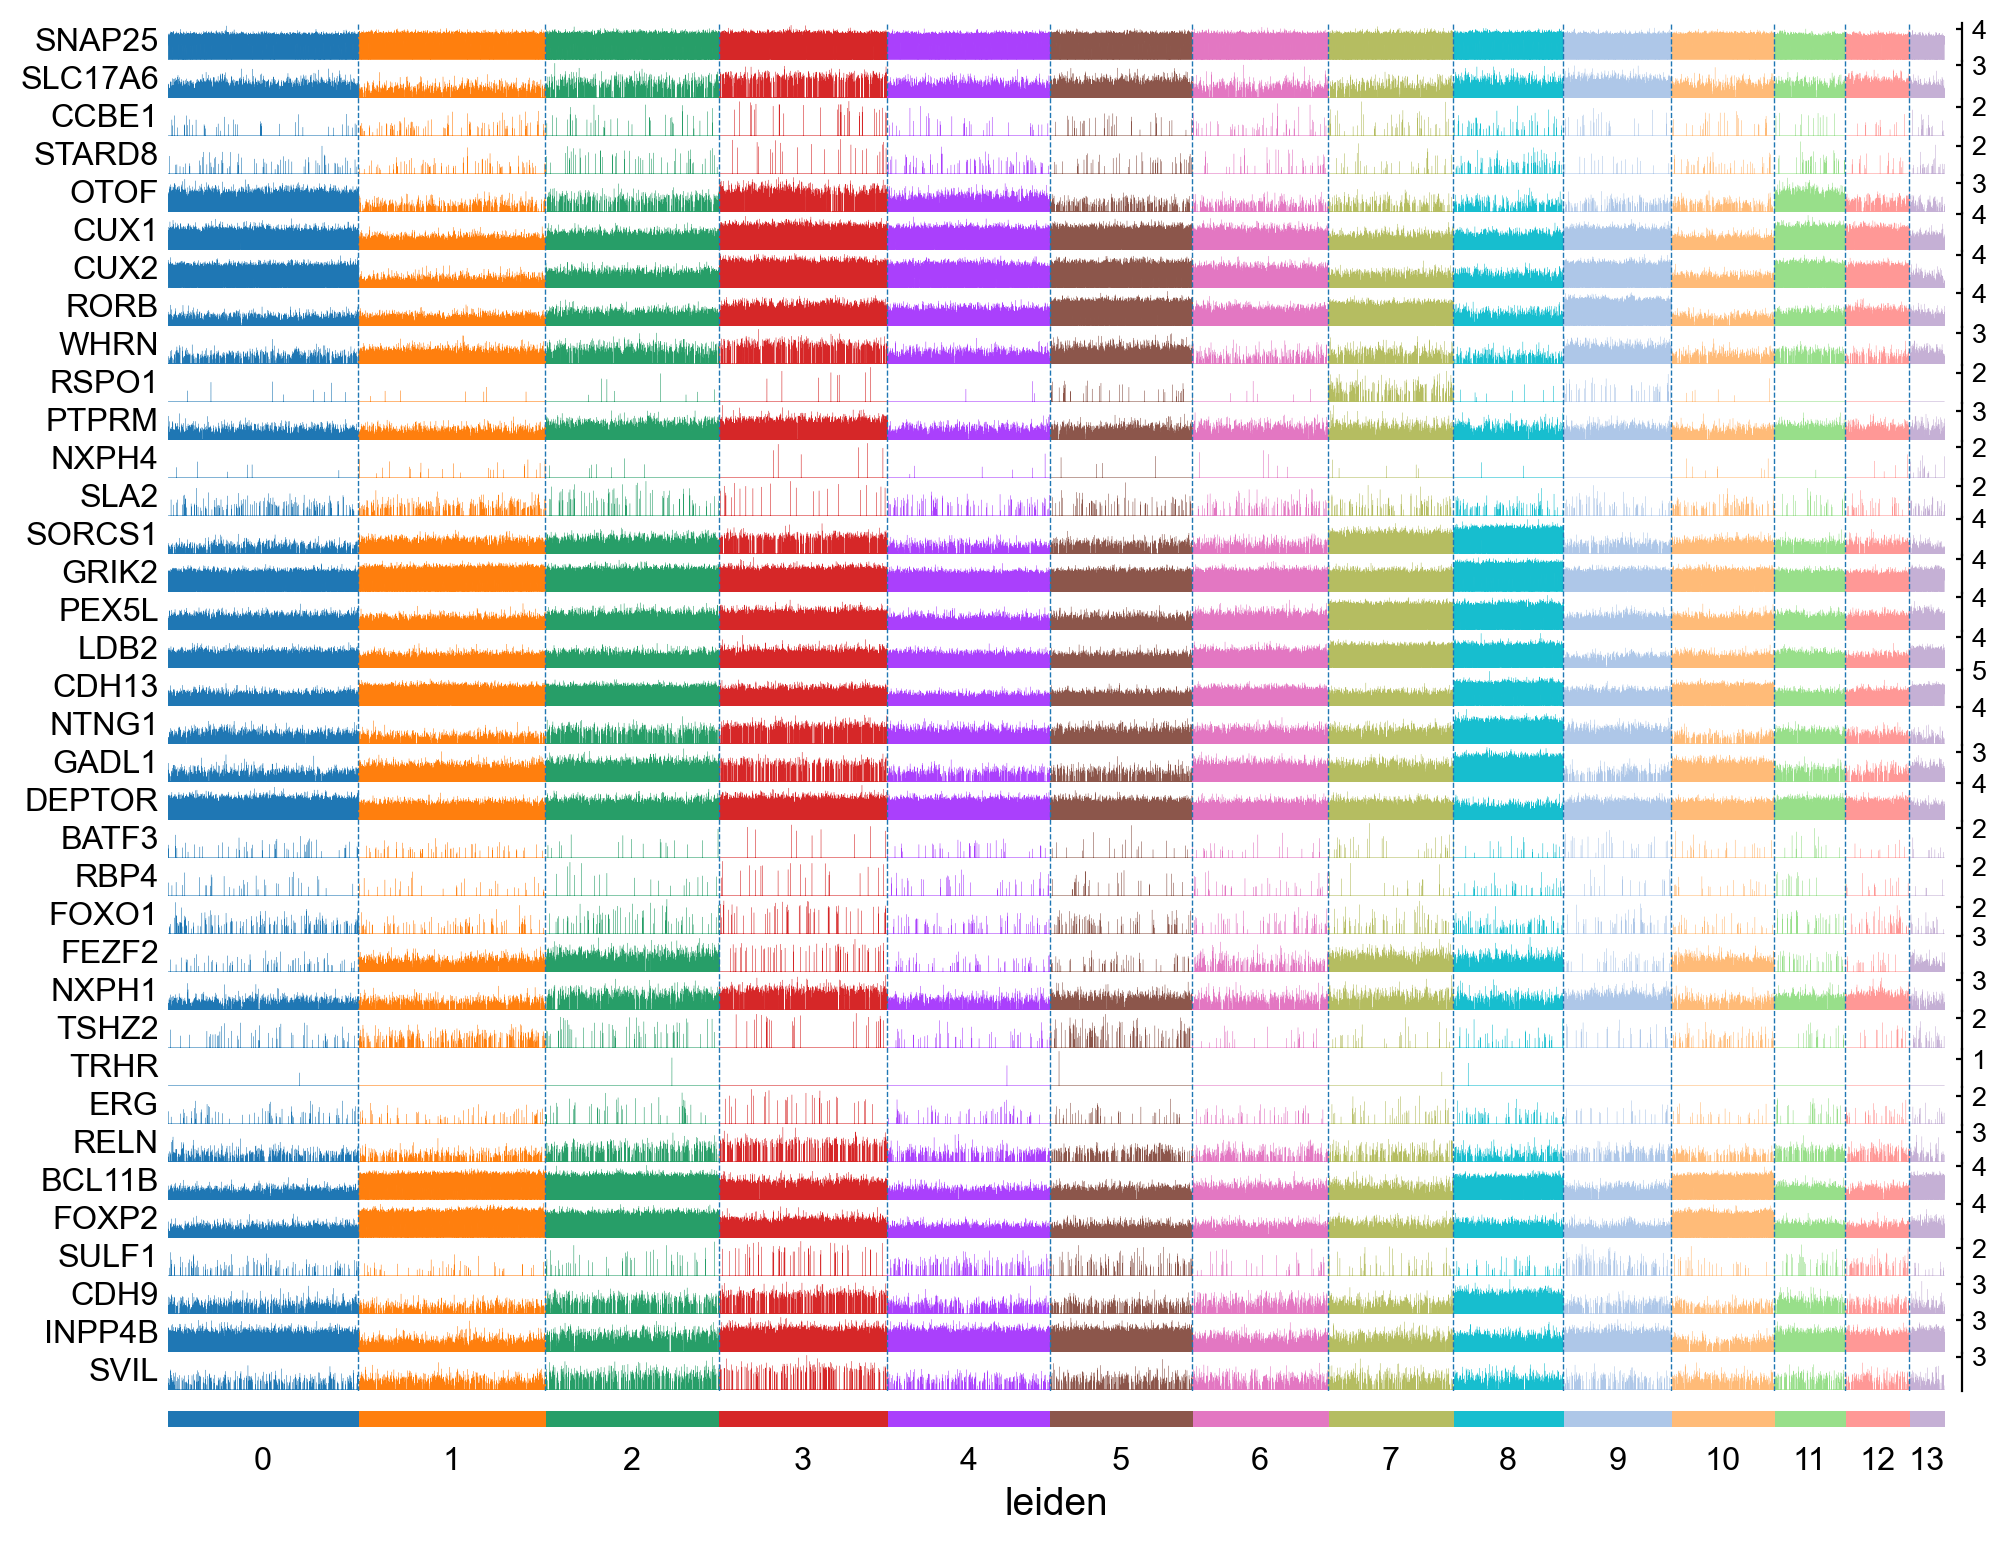

In [10]:
sc.pl.tracksplot(
    adata, 
    glutamatergic_markers, 
    groupby="leiden", 
    # dendrogram=True, 
    # swap_axes=True, 
    # vmin=0, vmax=4, 
    # var_group_positions=[(0, 1), (2, 4), (5, 6), (7, 8), (9, 23), (24, 28)], 
    # var_group_labels=["General", "2/3", "234", "4", "5", "6"], 
            )

In [11]:
adata_de = adata
adata_de.X = adata.raw.X
sc.tl.rank_genes_groups(adata_de, "leiden", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:07:23)


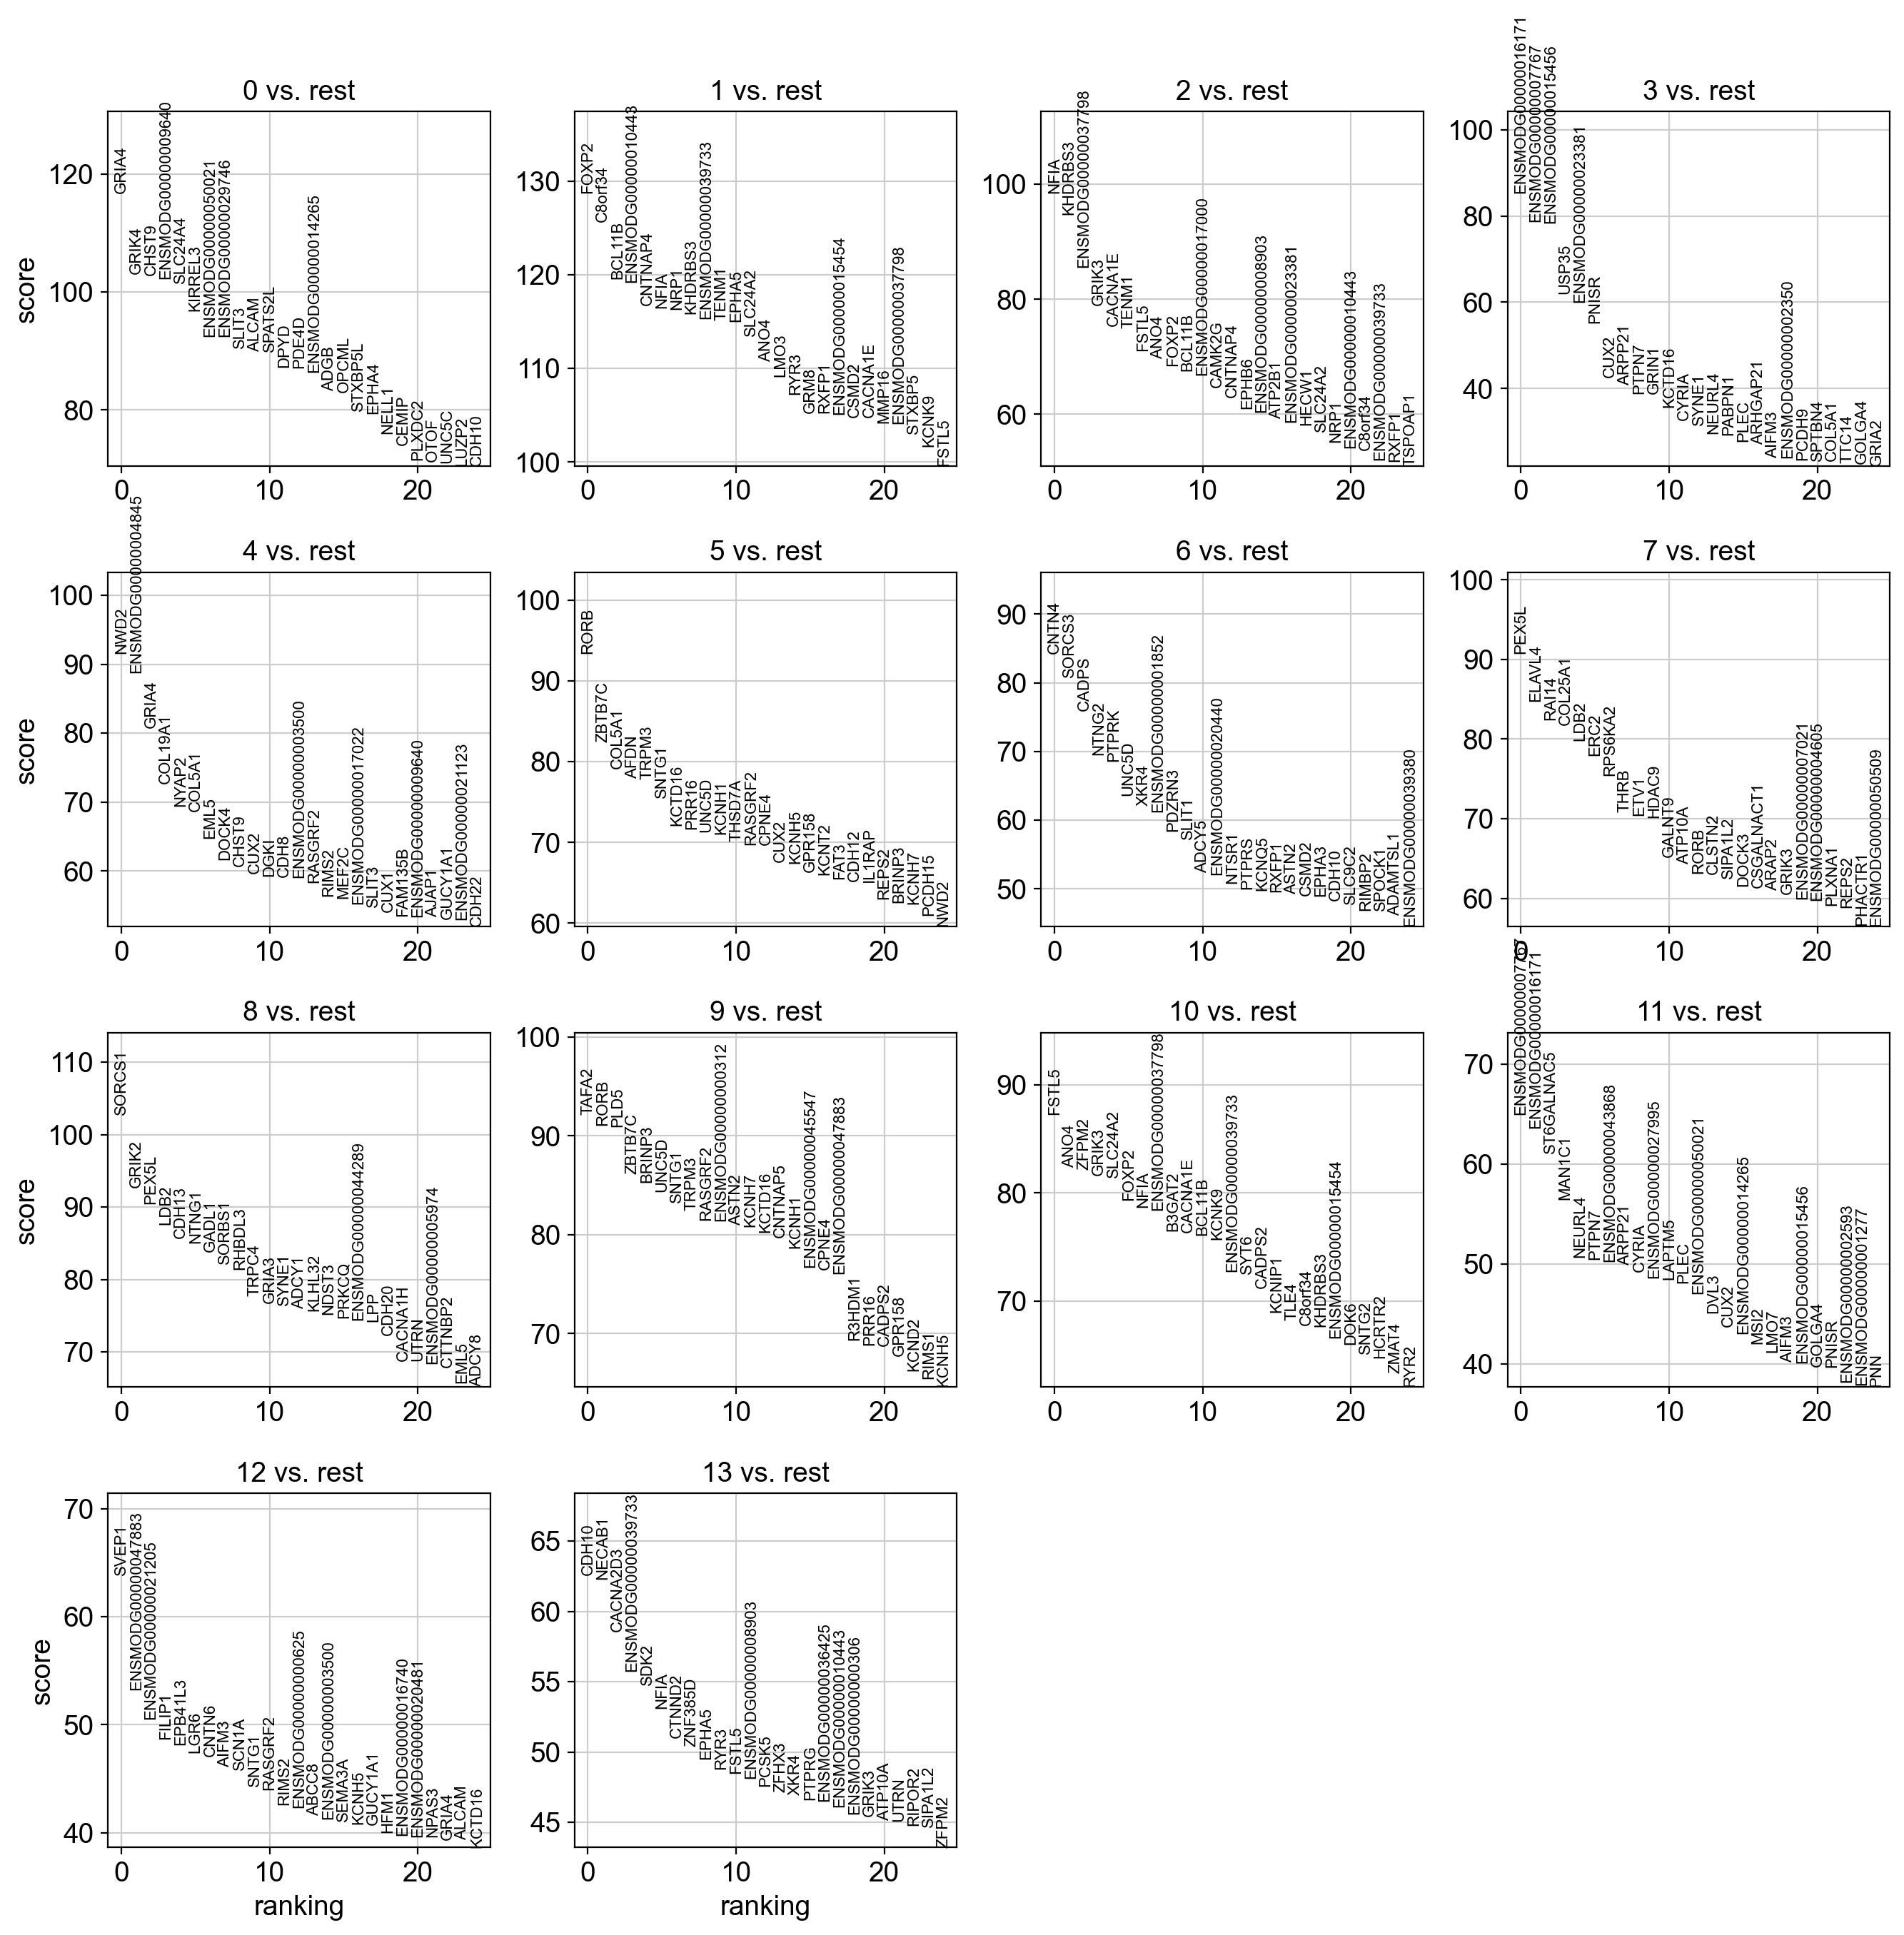

In [12]:
sc.pl.rank_genes_groups(adata_de, n_genes=25, sharey=False)